# Neural Networks for Data Science Applications
## End-of-term homework: Recurrent neural networks and autoregressive modelling

**Name**: *Lorenzo Pannacci*

**Matricola**: *1948926*

> ✍ Upload the completed notebook **at least two days** before your expected exam's date on the Google Classroom page. For example, for the **January 20th** session, you should upload it by **January 17th, 23:59 Rome time**.

In [ ]:
##############
# PARAMETERS #
##############

# for the training of the model on Kaggle's TPU machine
on_tpu = False

# recompute sequences or download them
from_scratch = False

# tokenizer settings
sequence_length = 128
separator_token = -1

# settings for the training
learning_rate = 0.001
batch_size = 2048
epochs = 100

# as explained later in the notebook those above are the hyperparameters
# for the real training that happened on a Kaggle TPU machine, to avoid
# long computation times and remain in the constraints of Colab machines
# I lower both batch size and number of epochs as the training that will
# be executed here is just a mock-up to show how it works and the real
# model will be downloaded later
batch_size = 256
epochs = 1

#########
# PATHS #
#########

# soundfont
sf2_path = r"/usr/share/sounds/sf2/FluidR3_GM.sf2"

# data
zip_name = r"nin_midi_files.zip"
songs_path = r"nin_midi_files"
note_data_path = r"note_data.pkl"
valid_indices_path = r"valid_indices.pkl"
tokenizer_path = r"tokenizer.pkl"
model_path = r"model.pkl"
loss_history_path = r"loss_history.pkl"
val_loss_history_path = r"val_loss_history.pkl"

# folders for elements saved during training
models_folder = r"models/"
optimizer_state_folder = r"optimizer_states/"
loss_history_folder = r"loss_history/"
val_loss_history_folder = r"val_loss_history/"

#############
# DOWNLOADS #
#############

# original data
dataset_drive = r"1WEbNzBTTYzc27NI89JI46kYD15sfZQks"

# processed data and tokenizer
note_data_drive = r"1Mt1nqB7c66ihR9jI8Cm-EaxieL_EUqQ6"
valid_indices_drive = r"116kSE59ohS6naLjUUJjrOadh7fcGCUqf"
tokenizer_drive = r"1XnVqy5A3txN24jBzXSL9cTnQdk8bwAcP"

# trained model and loss
model_drive = r"1exxhXxstTShXk95uyk4KpJqAI8oO8c8L"
loss_history_drive = r"1rmZswppnkI556PLKWyyZZknt3jRQEA6C"
val_loss_history_drive = r"1_AxlGHy8S09u8Z1lnnRrRh3F9Z8LR9sZ"

In [ ]:
%%capture
#######################
# DOWNLOAD COMPONENTS #
#######################

# install synthesizer to convert MIDI files into audio files
!sudo apt -qq install -y fluidsynth

# install required libraries
!pip -qq install pyfluidsynth pretty_midi miditok gdown

# update jax on the Kaggle TPU machine, its default version is outdated and
# uses jax.tree_map() instead jax.tree.map()
if on_tpu:
    !pip -qq install -U "jax[tpu]>=0.4.26" -f https://storage.googleapis.com/jax-releases/libtpu_releases.html

In [ ]:
####################
# IMPORT LIBRARIES #
####################

import jax
import jax.numpy as jnp
import jax.random as jrand
import matplotlib.pyplot as plt

# for music
import miditok                  # midi files tokenizer
import pretty_midi              # convert midi files into audio
import IPython.display as ipd   # display audio player on notebook

# to handle data loading
from torch.utils.data import Dataset, DataLoader
import numpy as np # for data loading since pytorch doesn't support jax

# other
import pandas as pd
from functools import partial
from pathlib import Path
import warnings
import glob
import pickle
import os

if on_tpu: # Kaggle TPU doesn't support tqdm.notebook
    from tqdm import tqdm
else:
    from tqdm.notebook import tqdm

### Instructions

1. The homework is divided into three exercises. The first two (**10 points**) are mandatory for everyone. The third one (**5 points**) is mandatory only if you have not submitted the first homework or if you want to increase the mark.
2. If you score well on the project but poorly on the oral, the grade can be kept for the entire academic year (up to October 2025).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>. **Same goes for LLM-generated material**.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and JAX*: the homework must be done _fully in JAX_ (no external libraries) and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

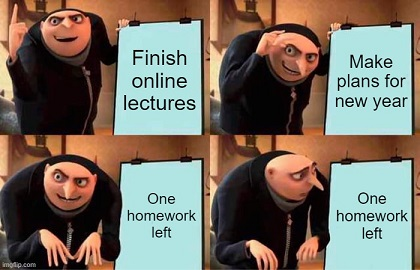

### Warmup: Data loading

For this part, select a dataset that is adequate for an autoregressive modelling task, keeping in mind task complexity with respect to the available hardware. Alternatively, take a generic dataset and transform it in a suitable way. Some examples (non exhaustive list):

1. Any text dataset can be converted to a next-token prediction dataset. You are free to use an existing tokenizer or train the tokenizer from scratch.
2. Time series are also naturally convertible to autoregressive scenarios.
3. For images you can convert them in multiple ways, e.g., as a sequence of pixels, as a sequence of patches (as in ViTs), as a sequence of bytes...
4. Other types of data, such as audio, graphs, DNA sequences, etc., are also feasible based on your interest.

> ⭕ For this homework, creativity is appreciated! Look around in the literature for inspiration (e.g., PixelRNN, pixel language modeling, audio autoregression, conditional models, ...). The fancier the better, according to your judgment.

*   You can use any data processing you want here (PyTorch data loaders, TensorFlow datasets, Grain, HuggingFace Dataset, ...).
*   You should use a **different dataset** from the first homework, possibly of higher complexity.
*   Any data type (tabular, images, videos, audio, time-series, graphs, ...) is okay.

✍ **DESCRIPTION OF THE CODE**

*Provide a description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code. Describe the preprocessing you have applied. Show some examples of tokenized sequences and / or some statistics (e.g., tokens count, sequence length, ...).*

---

The proposed task for the homework is **music generation**. Instead of dealing with this task as audio generation I decided to use data in the form of a collection of **MIDI** (Musical Instrument Digital Interface) files, which don't contain audio, but instead have information about which notes or chords are played, when they're played, their duration, loudness, the instrument and more. They are the kind of files used in music editing programs and are given to synthetizers to produce audio.

To constrain the task I **focused only on datasets containing piano melodies**, which for MIDI files still means $8$ different instruments (Acoustic Grand Piano, Bright Acoustic Piano, Electric Grand Piano, Honky-tonk Piano, Rhodes/Wurlitzer piano, FM piano patch, Harpsichord and Clavinet), that at least have a shared sense of musicality, being very similar instruments.

Online there are many available datasets for this task using MIDI files that span greatly both in size and variety. **Computational constraints are an extremely important driver in the choice of the dataset**, and this clashes with the task itself that by being generative usually requires large amounts of data. Colab's availability of resources is very limited and would have forced the use of a small dataset but fortunately Kaggle offers up to $30$ hours of GPU and $20$ hours of TPU computation weekly and thanks to this I was able to scale up the data as much as possible.

The dataset I ended up using is **"Nin Video Game MIDIs**" (available [here](https://www.kaggle.com/datasets/hansespinosa2/nin-video-game-midis)), a dataset of around $5.000$ MIDI files scraped from https://www.ninsheetmusic.org/, a website of human-made piano arrangements of video game music.

The tokenization is performed using the library MidiTok and in particular the tokenizer **REMI** (REpresentations for Music Information), introduced in the paper [Pop Music Transformer](https://dl.acm.org/doi/10.1145/3394171.3413671). The approach of this tokenizer is to represent characteristics like pitch, duration or tempo as individual tokens while they evolve in discretized time steps, interleaved in the sequence by specific "BAR" tokens that separate the characterization of notes. The settings of the tokenizer have been tuned to capture as much detail as possible about the original sequence and the resulting vocabulary size is of $662$ elements.

To create the training samples each song is tokenized and saved as a sequence of indices corresponding to the assigned classes. All the sequences are then stored as a single object and sequences are sampled from it (explicitly storing all samples would have required too much memory). To avoid taking sequences that contain the end of a song and the start of the next a special token "-1" is put between each song and sequences containing this token are ignored. To get an efficient batching the data is handled by a PyTorch DataLoader.

Tokenizing all the dataset and building sequences I was able to get about **25 milion sequences**, which are then separated into a classic 80-20 split for train and validation samples.

---

In [ ]:
#############################################
# FUNCTIONS FOR DATA PROCESSING AND LOADING #
#############################################

def get_data():
    '''
    Download and unzip dataset from .zip file saved on drive. Used to build
    the sequence dataset from scratch and for inference.
    '''

    if not os.path.exists(songs_path):
        !gdown -qq {dataset_drive}

        # ignore warnings about presence of non-english characters
        # in the file names
        !unzip -qqq {zip_name} 2>/dev/null


def get_from_drive():
    '''
    Download already computed tokenizer, note_data and valid_indices from
    drive. Useful since building the sequence dataset from scratch requires
    about 15 minutes.
    '''

    !gdown -qq {note_data_drive}
    !gdown -qq {valid_indices_drive}
    !gdown -qq {tokenizer_drive}

    with open(note_data_path, 'rb') as f:
        note_data = pickle.load(f)

    with open(valid_indices_path, 'rb') as f:
        valid_indices = pickle.load(f)

    with open(tokenizer_path, 'rb') as f:
        tokenizer = pickle.load(f)
        vocab_size = tokenizer.vocab_size

    return note_data, valid_indices, tokenizer, vocab_size


def initialize_tokenizer():
    '''
    Initialize tokenizer and vocab size parameter. Tokenizer is setted to
    capture most of the details from the MIDI file.

    The creation of the tokenizer is wrapped to ignore a warning given that
    says that the "attribute control" is not available for the current
    tokenizer settings, but we are not interested in using it.
    '''

    # configure tokenizer settings
    TOKENIZER_PARAMS = {"use_rests": True,
                        "use_chords": True,
                        "use_tempos": True,
                        "use_programs": True,
                        "use_pitch_bends": True,
                        "use_sustain_pedals": True,
                        "use_time_signatures": True,
                        "use_pitchdrum_tokens": False,
                        "sustain_pedal_duration": True,
                        "remove_duplicated_notes": True,
                        "one_token_stream_for_programs": True,
                        "delete_equal_successive_tempo_changes": True}

    # initialize tokenizer
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        config = miditok.TokenizerConfig(**TOKENIZER_PARAMS)
        tokenizer = miditok.REMI(config)

    # save tokenizer
    with open(tokenizer_path, 'wb') as f:
        pickle.dump(tokenizer, f)

    vocab_size = tokenizer.vocab_size

    return tokenizer, vocab_size


def get_note_data(songs_path):
    '''
    This function reads all the MIDI files inside the input path folder and
    converts them into sequences of notes, interleaved by a separation token.
    '''

    # get all midi files
    files = glob.glob(songs_path + "/**/*.mid", recursive=True)
    n_files = len(files)

    # list to collect all note data
    note_data = jnp.array([], dtype=jnp.int32)

    for i, song in tqdm(enumerate(files),
                        desc="Converting files to sequences", total=n_files):

        try:
            # tokenize song
            song_tokens = jnp.array(tokenizer(song))

            # add a separator token if not the first song
            if note_data.size > 0:
                note_data = jnp.append(note_data, jnp.array([separator_token]))

            # append to the rest
            note_data = jnp.append(note_data, song_tokens)

        except Exception as e:
            print(f"Error for file {song}: {e}")
            pass

    return note_data


def find_valid_indices(note_data, window_size):
    '''
    This function creates a list of indices from the note_data sequence such
    that a valid sequence can be taken. A sequence is considered valid if it
    has size equal to the sequence length plus one and it contains no separator
    tokens.
    '''

    sep_token_mask = note_data != separator_token

    # old versions of JAX seem to remain stuck in the computation of this?
    valid_sequences = jnp.convolve(sep_token_mask, jnp.ones(window_size, dtype=bool), mode='valid') == window_size

    valid_indices = jnp.where(valid_sequences)[0]

    return valid_indices


class MidiDataset(Dataset):
    '''
    Pytorch dataset class to handle giving sequence batches to the model.
    Instead of saving all possible sequences explicitly we sample indices
    and used them to extract sequences from note_data.

    Sequences are converted to NumPy since PyTorch does not support JAX arrays.
    '''

    def __init__(self, note_data, valid_indices, sequence_length):
        self.sequence_length = sequence_length
        self.note_data = np.array(note_data)
        self.valid_indices = np.array(valid_indices)


    def __len__(self):
        return len(self.valid_indices)


    def __getitem__(self, idx):
        # from index of valid_indices get sequence indices
        idx = self.valid_indices[idx]
        indices = np.arange(idx, idx + self.sequence_length)

        # from sequence indices get sample
        x = self.note_data[indices]
        y = self.note_data[idx + self.sequence_length]

        return x, y

In [ ]:
# by default the sequence dataset is not built froms scratch because
# it would take around 15 minutes to do so, but it is possible to
# force it by un-commenting the following line of code
#
# from_scratch = True
#
############################################
# EXECUTION OF DATA PROCESSING AND LOADING #
############################################

get_data()

if not from_scratch: # get already computed from drive
    note_data, valid_indices, tokenizer, vocab_size = get_from_drive()

else: # build data from scratch
    # get tokenizer
    tokenizer, vocab_size = initialize_tokenizer()

    # get sequence of all notes
    note_data = get_note_data(songs_path)

    # get indices to sample
    valid_indices = find_valid_indices(note_data, sequence_length+1)

print(f"Vocab size: {vocab_size}")
print(f"Note data shape: {note_data.shape}")
print(f"Valid indices shape: {valid_indices.shape}")

# random shuffle valid indices
valid_indices = jax.random.permutation(jrand.PRNGKey(42), valid_indices)

# split into train and validation indices; classic 80-20 split is used
train_size = int(0.8 * len(valid_indices))
train_indices = valid_indices[:train_size]
valid_indices = valid_indices[train_size:]

# initialize the custom datasets
train_set = MidiDataset(note_data, train_indices, sequence_length)
val_set = MidiDataset(note_data, valid_indices, sequence_length)

# create DataLoaders for batching
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# get sample batch
for batch_idx, (x, y) in enumerate(train_loader):
    print("Input sequence:", x.shape)
    print("Output sequence:", y.shape)
    break

Vocab size: 662
Note data shape: (24599030,)
Valid indices shape: (23961950,)
Input sequence: torch.Size([256, 128])
Output sequence: torch.Size([256])


---

Here is showed an example of tokenized sequence:

---

In [ ]:
# show tokenized song
print(list(tokenizer("/content/nin_midi_files/Sony/PS1/FinalFantasyVII/JENOVA.mid")))

[4, 500, 189, 352, 363, 66, 110, 128, 193, 363, 65, 114, 128, 197, 363, 61, 115, 128, 201, 363, 58, 114, 128, 205, 363, 54, 115, 128, 209, 363, 53, 114, 128, 213, 363, 49, 115, 128, 217, 363, 46, 114, 128, 4, 500, 189, 363, 66, 116, 128, 193, 363, 65, 114, 128, 197, 363, 61, 115, 128, 201, 363, 58, 114, 128, 205, 363, 54, 115, 128, 209, 363, 53, 114, 128, 213, 363, 49, 115, 128, 217, 363, 46, 114, 128, 4, 500, 189, 363, 66, 116, 128, 193, 363, 65, 114, 128, 197, 363, 61, 115, 128, 201, 363, 58, 114, 128, 205, 363, 54, 115, 128, 209, 363, 53, 114, 128, 213, 363, 49, 115, 128, 217, 363, 46, 114, 128, 4, 500, 189, 363, 66, 116, 128, 193, 363, 65, 114, 128, 197, 363, 61, 115, 128, 201, 363, 58, 114, 128, 205, 363, 54, 115, 128, 209, 363, 53, 114, 128, 213, 363, 49, 115, 128, 217, 363, 46, 114, 128, 4, 500, 189, 363, 22, 115, 128, 363, 46, 112, 172, 363, 49, 112, 172, 363, 52, 115, 172, 193, 363, 25, 114, 128, 197, 363, 22, 114, 128, 201, 363, 25, 114, 128, 205, 363, 30, 115, 128, 209, 363,

---

To have a better understanding a table of the class indentifiers and their corresponding tokens in the sequence order is shown.

---

In [ ]:
# show table of token ids and token content

inverse_vocab = {v: k for k, v in tokenizer.vocab.items()}

tokens = list(tokenizer("/content/nin_midi_files/Sony/PS1/FinalFantasyVII/JENOVA.mid"))
inverse_tokens = [inverse_vocab[elem] for elem in tokens]

df = pd.DataFrame({'ID': tokens, 'Token': inverse_tokens})

df.head(10)

,ID,Token
0,4,Bar_None
1,500,TimeSig_4/4
2,189,Position_0
3,352,Tempo_182.26
4,363,Program_0
5,66,Pitch_82
6,110,Velocity_71
7,128,Duration_0.4.8
8,193,Position_4
9,363,Program_0


---

Lastly a histogram of tokens in the whole dataset is potted:

---

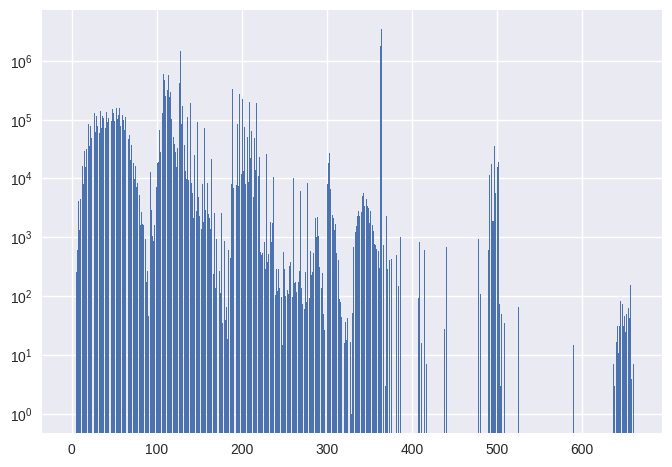

In [ ]:
# plot token histogram in whole note data

unique, counts = jnp.unique(note_data, return_counts=True)

plt.style.use('seaborn-v0_8')
plt.bar(unique, counts)
plt.yscale('log')

plt.show()

---

The parts with low to no frequency of tokens of the histogram are those related to the "Programs" (i.e. instruments), which is expected since the dataset if made solely of piano melodies and those related to "Pedals", which seem to not be used much in the dataset.

---

### Exercise 1: Training a recurrent model (7 points)

For this exercise, you are asked to implement a recurrent neural network, **entirely in JAX** (no higher-level libraries). Examples include all the content of Lecture 10 in the course (vanilla RNNs, structured state-space models, ...) but also other types of recurrent models you may find in the literature.

> 🟨 Depending on the implementation, you may need to be careful in the forward pass. For example, consider using [jax.lax.scan](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html) for implementing the loop of a vanilla RNN.

> 🟥 Remember that the homework must be done fully in JAX, with no external libraries (when in doubt, ask).

✍ **DESCRIPTION OF THE CODE**

*Provide a description of what you are implementing, both as text and in the comments of the code. Importantly, describe carefully the design of the model. Train the model and show some plots to visualize the training (e.g., loss curves, perplexity, ...).*

---

Searching online for music generations models that employ RNNs I found out that the vast majority of them uses **Long short-term memory (LSTM)**, so I decided to base my model on them too.

Since the output of the tokenization is a sequence in the form of a list of indices the first layer of the model is an **embedding layer**, which is essentially used as a learnable lookup table that maps for each token its embedding.

After the embeddings I have put two **LSTM layers**, the first keeping the sequence shape of the input by returning the whole output sequence and the second removing the sequence dimension by returning only the last element of the output sequence.

Lastly there are two **fully-connected layers** that perform the classification of the next token.

LSTM layers and fully-connected layers are interleaved with **dropout layers**, useful to avoid overfitting.

The starting weights are setted using Xavier's initialization, with implementation inspired from the code in "*Lab 3: Vision Transformers in JAX*".

The following code contains all the *init* and *call* functions for all the implemented layers as well as loss, prediction and metrics functions, the optimizer step and the training loop.

---

In [ ]:
###################
# EMBEDDING LAYER #
###################

def init_embedding(key, vocab_size, embedding_dim):
    '''
    Initialization for the embedding layer.

    Starting weights are setted using Xavier's initialization. Parameters
    for embedding layer is a single matrix of size [vocab_size, embedding_dim],
    it associates to each "class" of tokens its embedding as a lookup table.
    '''

    # intervals for Xavier's initialization
    limit = jnp.sqrt(6.0 / (vocab_size + embedding_dim))

    # initialization of lookup table
    W = jax.random.uniform(key=key,
                           shape=(vocab_size, embedding_dim),
                           minval=-limit,
                           maxval=limit)

    return W


@jax.jit
def call_embedding(x, params):
    '''
    Forward pass for the embedding layer. An embedding layer works as a lookup
    table, for each token it returns its embedding as the correspective row
    in the matrix.
    '''

    W = params

    return jnp.take(W, x, axis=0).squeeze(axis=-2)


##############
# LSTM LAYER #
##############

def init_lstm(key, input_dim, hidden_dim):
    """
    'input_dim': size of the embeddings that are inputted to the LSTM.
    'hidden_dim': size of the states of the LSTM.

    W: matrix multiplies the hidden state [hidden_dim, hidden_dim]
    U: matrix that multiplies the input [input_dim, hidden_dim]
    b: bias [1, hidden_dim]

    f: forget gate
    i: input gate
    o: output gate
    c: new content for cell state

    Starting weights are setted using Xavier's initialization and biases
    are initialized with zeros.
    """

    # split keys
    keys = jax.random.split(key, num=8)

    # intervals for Xavier's initialization
    limit_W = jnp.sqrt(6.0 / (hidden_dim + hidden_dim))
    limit_U = jnp.sqrt(6.0 / (input_dim + hidden_dim))

    # forget gate weights and biases
    W_f = jax.random.uniform(key=keys[0],
                             shape=(hidden_dim, hidden_dim),
                             minval=-limit_W,
                             maxval=limit_W)

    U_f = jax.random.uniform(key=keys[1],
                             shape=(input_dim, hidden_dim),
                             minval=-limit_U,
                             maxval=limit_U)

    b_f = jnp.zeros(shape=(1, hidden_dim))

    # input gate weights and biases
    W_i = jax.random.uniform(key=keys[2],
                             shape=(hidden_dim, hidden_dim),
                             minval=-limit_W,
                             maxval=limit_W)

    U_i = jax.random.uniform(key=keys[3],
                             shape=(input_dim, hidden_dim),
                             minval=-limit_U,
                             maxval=limit_U)

    b_i = jnp.zeros(shape=(1, hidden_dim))

    # output gate weights and biases
    W_o = jax.random.uniform(key=keys[4],
                             shape=(hidden_dim, hidden_dim),
                             minval=-limit_W,
                             maxval=limit_W)

    U_o = jax.random.uniform(key=keys[5],
                             shape=(input_dim, hidden_dim),
                             minval=-limit_U,
                             maxval=limit_U)

    b_o = jnp.zeros(shape=(1, hidden_dim))

    # new content weights and biases
    W_c = jax.random.uniform(key=keys[6],
                             shape=(hidden_dim, hidden_dim),
                             minval=-limit_W,
                             maxval=limit_W)

    U_c = jax.random.uniform(key=keys[7],
                             shape=(input_dim, hidden_dim),
                             minval=-limit_U,
                             maxval=limit_U)

    b_c = jnp.zeros(shape=(1, hidden_dim))

    return W_f, U_f, b_f, W_i, U_i, b_i, W_o, U_o, b_o, W_c, U_c, b_c


@partial(jax.jit, static_argnames=['return_all'])
def call_lstm(x, params, return_all):
    """
    The forward pass takes as input a sequence of embeddings and cycles
    sequentially through each embedding computing the hidden and cell states.

    The starting states are made of zeros for each sequence.

    As suggested by the homework the inevitable 'for' cycle of the LSTM is
    performed in a more efficient way thanks to the 'scan' function of jax.
    """

    def lstm_step(carry, x_t):
        h_t, c_t = carry

        # get gate outputs
        f_t = jax.nn.sigmoid(h_t @ W_f + x_t @ U_f + b_f)
        i_t = jax.nn.sigmoid(h_t @ W_i + x_t @ U_i + b_i)
        o_t = jax.nn.sigmoid(h_t @ W_o + x_t @ U_o + b_o)

        # get new content
        c_tilde = jnp.tanh(h_t @ W_c + x_t @ U_c + b_c)

        # update states
        c_t = f_t * c_t + i_t * c_tilde
        h_t = o_t * jnp.tanh(c_t)

        return (h_t, c_t), h_t

    # split params
    W_f, U_f, b_f, W_i, U_i, b_i, W_o, U_o, b_o, W_c, U_c, b_c = params

    # swap batch_size and seq_length dimensions since scan
    # works only on the first dimension
    x = jnp.swapaxes(x, 0, 1)

    # initialization of hidden state and cell state for each sequence
    h0 = jnp.zeros(shape=(x.shape[1], b_f.shape[1]))
    c0 = jnp.zeros(shape=(x.shape[1], b_f.shape[1]))

    # use jax.lax.scan to iterate over the sequence
    # input 'x' has shape [batch_size, seq_length, emb_size]
    (h_final, _), h_all = jax.lax.scan(lstm_step, (h0, c0), x)

    # modality of the LSTM, if we want to keep the sequence dimension or not
    if return_all:
        h_all = jnp.swapaxes(h_all, 0, 1)
        return h_all
    else:
        return h_final


###############
# DENSE LAYER #
###############

def init_dense(key, input_dim, output_dim):
    '''
    Initialization for the fully-connected layer.

    Starting weights are setted using Xavier's initialization and biases
    are initialized with zeros.
    '''

    # intervals for Xavier's initialization
    limit = jnp.sqrt(6.0 / (input_dim + output_dim))

    W = jax.random.uniform(key=key,
                           shape=(input_dim, output_dim),
                           minval=-limit,
                           maxval=limit)

    b = jnp.zeros(shape=(1, output_dim))

    return W, b


@jax.jit
def call_dense(x, params):
    '''
    Forward pass for the fully-connected layer.
    '''

    # split params
    W, b = params

    return x @ W + b

#################
# DROPOUT LAYER #
#################

@partial(jax.jit, static_argnames=['is_training'])
def dropout(x, rate, key, is_training):
    '''
    Implementation of a simple dropup layer, used to reduce overfitting.
    '''

    if not is_training:
        return x

    keep_prob = 1.0 - rate
    mask = jax.random.bernoulli(key, keep_prob, shape=x.shape)

    return x * mask / keep_prob


###############
# WHOLE MODEL #
###############

def init_model(key):
    '''
    Initialization for the whole model.
    '''

    # split keys
    keys = jax.random.split(key, num=5)

    # embedding layer
    embedding_params = init_embedding(keys[0], vocab_size, 512)

    # lstm that return sequences
    lstm_1_params = init_lstm(keys[1], 512, 512)

    # lstm that return last state
    lstm_2_params = init_lstm(keys[2], 512, 512)

    # dense layer 1
    dense_1_params = init_dense(keys[3], 512, 512)

    # dense layer 2
    dense_2_params = init_dense(keys[4], 512, vocab_size)

    return embedding_params, lstm_1_params, lstm_2_params, dense_1_params, dense_2_params


@partial(jax.jit, static_argnames=['is_training'])
def call_model(x, params, is_training, key, temperature=None):
    '''
    Forward pass for the whole model.
    '''

    # split keys
    keys = jax.random.split(key, num=3)

    # split params
    embedding_params, lstm_1_params, lstm_2_params, dense_1_params, dense_2_params = params

    # embedding layer
    x = call_embedding(x, embedding_params)
    x = dropout(x, 0.3, keys[0], is_training)

    # first lstm layer maintain the sequence structure of the input
    x = call_lstm(x, lstm_1_params, return_all=True)
    x = dropout(x, 0.3, keys[1], is_training)

    # second lstm layer removes the sequence structure from the input
    x = call_lstm(x, lstm_2_params, return_all=False)

    x = call_dense(x, dense_1_params)
    x = dropout(x, 0.3, keys[2], is_training)

    logits = call_dense(x, dense_2_params)

    if temperature is not None: # temperature used only for prediction
        logits /= temperature

    output = jax.nn.log_softmax(logits)

    return output

In [ ]:
################################
# LOSS, PREDICTION AND METRICS #
################################

@jax.vmap
def cross_entropy(y_true, y_pred):
    '''
    Computes the cross-entropy loss between the true labels and the predicted
    probabilities.
    '''

    return -(y_true * y_pred).sum()


@partial(jax.jit, static_argnames=['is_training'])
@jax.value_and_grad
def loss(params, x, y_true, is_training, key):
    '''
    Computes the loss mean of the model for a given batch ofinputs and their
    ground truths.
    '''

    y_pred = call_model(x, params, is_training, key)
    loss = cross_entropy(y_true, y_pred).mean()

    return loss


@jax.jit
def prediction(x, params, key, temperature=1.0):
    '''
    Function that take a sequence and the model parameters and generates the
    next token index using the model. Used for inference.
    '''

    probs = call_model(x, params, False, key, temperature)
    pred = jax.random.categorical(key, probs)

    return pred


def perform_validation(params, val_loader, key):
    '''
    Computes the mean validation loss over the validation set using
    the current model. Done at the end of an epoch.
    '''

    loss_history = []

    for i, (x, y) in enumerate(val_loader):

        # convert batch from numpy to jax
        x = jnp.asarray(x).reshape(-1, sequence_length, 1)
        y = jax.nn.one_hot(jnp.asarray(y), vocab_size)

        # compute loss
        loss_value, _ = loss(params, x, y, False, key)

        # save loss value
        loss_history.append(loss_value)

    # return mean validation loss
    return jnp.mean(jnp.array(loss_history))


@jax.jit
def accuracy(y, y_pred):
    return (y.argmax(axis=1) == y_pred.argmax(axis=1)).mean()


@jax.jit
def perplexity(y, y_pred):
    return jnp.exp(-loss(y, y_pred))

---

As optimizer I chose to implement **RMSProp**, an optimization algorithm that adapts the learning rate for each parameter by keeping as "state" a moving average of the square gradients:

$s_t = \beta s_{t-1} + (1 - \beta) g_t^2$

Where $s_t$ is the new state, $s_{t-1}$ the previous state, $g_t$ the current gradient and $\beta$ a decay rate. This state is then used to **scale the learning rate**, obtaining the following update formula:

$p_t = p_{t-1} - \frac{\alpha}{\sqrt{s_t + \epsilon}}g_t$

Where $p_t$ is the updated parameter, $p_{t-1}$ the parameter before the update, $\alpha$ the learning rate and $\epsilon$ a small positive value to avoid division by zero.

This reasoning is applied to each parameter of the model using the *jax.tree.map()* method.

---

In [ ]:
################
# OPTIMIZATION #
################

def rmsprop_init(params, decay_rate=0.9):
    '''
    Initializes the optimizer state for the RMSProp algorithm.
    '''

    state = jax.tree.map(lambda p: jnp.zeros_like(p), params)
    return state


@jax.jit
def rmsprop_step(params, grads, state, learning_rate=0.001, decay_rate=0.9, epsilon=1e-8):
    '''
    Updates the model parameters using the RMSProp algorithm.
    '''

    # update the moving average
    state_new = jax.tree.map(lambda s, g: decay_rate * s + (1 - decay_rate) * (g ** 2),
                             state,
                             grads)

    # compute the parameter updates
    updates = jax.tree.map(lambda g, s: - learning_rate * g / (jnp.sqrt(s) + epsilon),
                           grads,
                           state_new)

    # apply updates to parameters
    params_new = jax.tree.map(lambda p, u: p + u, params, updates)

    # return the updated parameters and new optimizer state
    return params_new, state_new


def train_model(params, train_loader, val_loader, epochs, learning_rate, save_frequency, key):
    '''
    Implements the training loop of the model. It also saves the history of
    train loss and validation for plotting and the optimizer state to resume
    training after an interruption.
    '''

    # init rmsprop
    opt_state = rmsprop_init(params)

    # init vectors to save train loss and val loss
    loss_history = []
    val_loss_history = []

    for epoch in (tqdm(range(epochs))): # cycle through epochs

        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader),
                            desc=f"Epoch {epoch+1}/{epochs}", position=0, leave=True)

        for i, (x, y) in progress_bar: # cycle through batches

            # convert batch from numpy to jax
            x = jnp.asarray(x).reshape(-1, sequence_length, 1)
            y = jax.nn.one_hot(jnp.asarray(y), vocab_size)

            # split key
            key, subkey = jax.random.split(key)

            # compute loss and gradients
            loss_value, grads = loss(params, x, y, True, subkey)
            progress_bar.set_description(f"\rEpoch: {epoch+1} - Batch: {i+1} - Loss: {loss_value}")

            # clip gradients for stability
            # grads = jax.tree.map(lambda g: jnp.clip(g, -1, 1), grads)

            # save loss value
            loss_history.append(loss_value)

            # update parameters
            params, opt_state = rmsprop_step(params, grads, opt_state, learning_rate)

        # perform validation at end of epoch
        val_loss_value = perform_validation(params, val_loader, subkey)
        val_loss_history.append(val_loss_value)

        print(f"Validation loss: {val_loss_value}")

        # save model, optimizer state and metrics every 'save_frequency' epochs
        if epoch % save_frequency == 0:
            with open(f'{models_folder}model_epoch_{epoch}.pkl', 'wb') as f:
                pickle.dump(params, f)

            with open(f'{optimizer_state_folder}optimizer_epoch_{epoch}.pkl', 'wb') as f:
                pickle.dump(opt_state, f)

            with open(f'{loss_history_folder}loss_epoch_{epoch}.pkl', 'wb') as f:
                pickle.dump(loss_history, f)

            with open(f'{val_loss_history_folder}loss_epoch_{epoch}.pkl', 'wb') as f:
                pickle.dump(val_loss_history, f)

    return params, loss_history, val_loss_history

---

Here the model and other things required for the training are initialized. Also a count of the amount of parameters of the model is shown and it can be seen that **the model is made of more than 5 milion parameters**.

---

In [ ]:
# init model
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)
params = init_model(subkey)

# create folders for save models, optimizer states and metrics
os.makedirs(models_folder, exist_ok=True)
os.makedirs(optimizer_state_folder, exist_ok=True)
os.makedirs(loss_history_folder, exist_ok=True)
os.makedirs(val_loss_history_folder, exist_ok=True)

# count the number of parameters in the model
n_params = sum(p.size for p in jax.tree.leaves(params))
print(f"Number of parameters: {n_params}")

Number of parameters: 5139606


---

Given the large size of the dataset training times are extremely long. One single epoch plus the validation step on CPU would take up to $600$ hours and around $6$ hours on GPU (at least on Kaggle's P100), while only taking $1$ hour and a half on TPU (Kaggle's TPU VM v3-8). The real training of the model is performed using RMSprop with learning rate $0.001$ and a batch size of $2048$ on a TPU machine from Kaggle (for memory constraints here the batch size is reduced to $256$).

After training an epoch the mean validation loss is computed and the criterion for stopping the training is when the validation loss stops decreasing, which happened after $16$ epochs, which are roughly equivalent $24$ hours of training on TPU. The loss data regarding the original training are downloaded from Google Drive and shown later.

It can be noticed that for the first batches the loss tends to increase, this is due to the initialization of the optimizer states and is quickly solved after a few steps.

Here is shown a mock-up version of the training, **the user should manually stop this cell to progress through the notebook**. The training cell is programmed to catch the KeyboardInterrupt error so that the next cells don't have to be manually executed if "Run All" has been used. After clicking to stop the cell you could wait up $30$ seconds for the current batch to finish its computation.

---

In [ ]:
# perform train loop
try:
    params, loss_history, val_loss_history = train_model(params, train_loader, val_loader, epochs, learning_rate, 1, key)

except KeyboardInterrupt:
    print("Training interrupted manually")

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1:   0%|          | 0/74882 [00:00<?, ?it/s]

Training interrupted manually


---

The metrics related to the training of the fully-trained model are downloaded and shown below. The plot contains the evolution of the train loss captured batch-by-batch, a moving average of the train loss with a window size equal to the amount of batches in one epoch and the mean validation loss over the validation set computed at the end of each epoch.

---

In [ ]:
# download files
!gdown -qq {loss_history_drive}
!gdown -qq {val_loss_history_drive}

# load from pickle
with open("/content/loss_history.pkl", 'rb') as f:
    loss_history = pickle.load(f)

with open("/content/val_loss_history.pkl", 'rb') as f:
    val_loss_history = pickle.load(f)

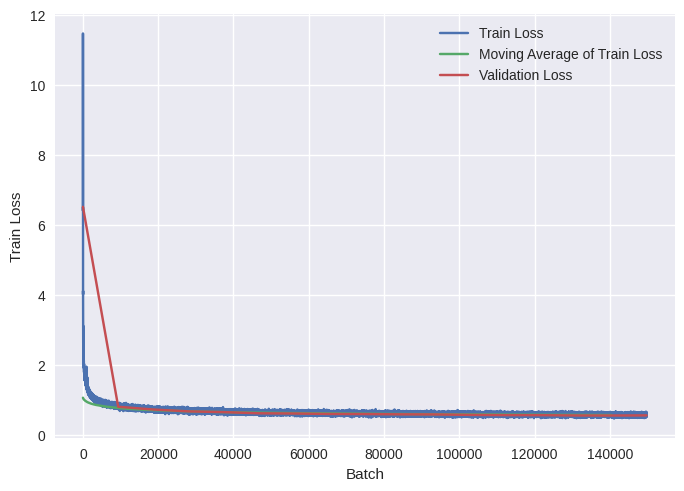

In [ ]:
moving_avg = np.convolve(loss_history, np.ones(9361)/9361, mode='valid')

plt.style.use('seaborn-v0_8')
plt.plot(loss_history, label="Train Loss")
plt.plot(moving_avg, label="Moving Average of Train Loss")
plt.plot(np.arange(len(val_loss_history)) * 9361, val_loss_history, label="Validation Loss")
plt.xlabel('Batch')
plt.ylabel('Train Loss')
plt.legend()
plt.show()

---

We cut off the first epoch to better understand what is happening in the plot. It may seem that the validation loss is lower than the average of the train loss but this most likely because the moving average is actually one epoch behind, since it uses the progressively improved model while the validation loss uses the model obtained at the end of the epoch.

---

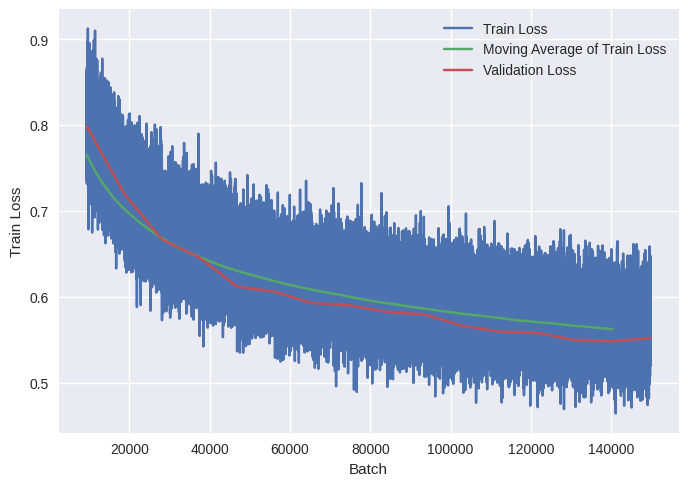

In [ ]:
plt.style.use('seaborn-v0_8')
plt.plot(np.arange(len(loss_history))[9361:], loss_history[9361:], label="Train Loss")
plt.plot(np.arange(len(moving_avg))[9361:], moving_avg[9361:], label="Moving Average of Train Loss")
plt.plot(np.arange(len(val_loss_history))[1:] * 9361, val_loss_history[1:], label="Validation Loss")
plt.xlabel('Batch')
plt.ylabel('Train Loss')
plt.legend()
plt.show()

### Exercise 2: Autoregressive generation (3 points)

For this exercise, run the trained model in an autoregressive fashion and show some examples of generated sequences. Note that the details will depend on the specific type of data (e.g., sampling text tokens, sampling pixels as discrete values, sampling pixels from a continuous range of colours, ...). For this, refer also to Section 8.4 of the book.

✍ **DESCRIPTION OF THE CODE**

*Provide a description of what you are implementing, both as text and in the comments of the code. Show some examples of generated sequences.*

---

Autoregressive generation is implemented by repeatedly making a next note prediction, saving the result and shifting the context window by removing the first element of the sequence and adding the new generated token as last. After generation the sequences are converted back into MIDI files and then synthetized to obtain audio, which is then displayed in the cells themselves as audio player widgets. **Be mindful that the audio displays are generated at maximum volume! There is no way to change that in the code, it is recommended to adjust it accordingly.**

The generation is usually setted to 4 times the starting sequence length (i.e. 512 tokens), and it takes around 1 minute and 15 seconds on Colab's CPU and less than 10 seconds on GPU.

Other utility functions as the extraction of sequences from songs are implemented as well as a function to confront the starting audio sequence, the true continuation and the generated one.

For the choice of sequences I decided to use songs that I personally know of to immediately grasp the difference between the original sequence and the generated one. A little bit of cherry picking is performed, but situations where the model fails are also shown.

Empirically I found that usually better results are produced with temperatures between $0.5$ and $1.1$ and that usually the generated sequence having a similar length (in seconds) to the original sequence is a good indicator of the sequence sounding good and not going too much off the rails.

---

In [ ]:
#####################################
# FUNCTIONS FOR SEQUENCE GENERATION #
#####################################

def import_model_and_tokenizer(model_path, tokenizer_path):
    '''
    Imports the model and the tokenizer from the given paths.
    '''

    with open(model_path, 'rb') as f:
        params = pickle.load(f)

    with open(tokenizer_path, 'rb') as f:
        tokenizer = pickle.load(f)

    return params, tokenizer


def sequence_to_midi(sequence, midi_path):
    '''
    Convert a sequence of IDs into MIDI file and save it to the given path.
    '''

    untokenized = tokenizer(sequence)
    untokenized.dump_midi(midi_path)


def midi_to_audio(midi_path):
    '''
    Converts a MIDI file to an waveform using the synthetizer and
    return it in an audio player in the output of the cell.
    '''

    # import midi file
    music = pretty_midi.PrettyMIDI(midi_file=midi_path)

    # convert midi to audio
    waveform = music.fluidsynth(sf2_path=sf2_path)

    # return audio player
    return ipd.Audio(waveform, rate=44100)


def sequence_to_audio(sequence, midi_path):
    '''
    Concatenate sequence to midi and midi to audio.
    '''

    sequence_to_midi(sequence, midi_path)

    return midi_to_audio(midi_path)


def get_sequence(midi_path, start_index, end_index):
    '''
    Returns a sequence of notes from a MIDI file and chosen interval
    of values.
    '''

    sequence = jnp.array(tokenizer(midi_path)[start_index:end_index])

    return sequence.reshape(-1, 1)


def generate_sequence(params, input_sequence, n_notes, key, temperature):
    '''
    Generates a sequence of tokens starting from the given input sequence
    using the model and the temperature of choice.
    '''

    prediction_output = []
    input_sequence = jnp.array(input_sequence).reshape(-1, 1)

    for i, note_index in tqdm(enumerate(range(n_notes)),
                              desc="Generating notes", total=n_notes):

        # split key
        key, subkey = jax.random.split(key)

        # prepare input
        prediction_input = jnp.reshape(input_sequence, (1, len(input_sequence), 1))

        # perform prediction
        pred = prediction(prediction_input, params, subkey, temperature=temperature).item()

        # extract prediction
        new_element = jnp.array([pred]).reshape(-1, 1)

        # insert prediction in the input sequence
        input_sequence = jnp.concatenate([input_sequence, new_element], axis=0)

        # remove oldest element from input sequence
        if len(input_sequence) > sequence_length:
            input_sequence = input_sequence[1:len(input_sequence)]

        # add predictioin to generated notes
        prediction_output.append(pred)

    return prediction_output


def generate_from_selected(params, tokenizer, n_notes, key, input_sequence, temperature, concatenate):
    '''
    Generates a sequence starting from a given sequence.
    '''

    input_sequence = jnp.array(input_sequence).reshape(-1, 1)

    # get prediction
    prediction_output = generate_sequence(params, input_sequence, n_notes, key, temperature)

    if concatenate:
        # concatenate to staring point
        to_convert = jnp.concatenate([input_sequence.flatten(), jnp.array(prediction_output)],
                                    axis=0, dtype=int).tolist()
    else:
        to_convert =  jnp.array(prediction_output, dtype=int).tolist()

    return sequence_to_audio(to_convert, "gen_audio.mid")


def tokenize_and_untokenize(tokenizer, midi_path):
    '''
    For testing purposes, it tokenizes and untokenizes a MIDI file, used
    to check thequality of the tokenizer.
    '''

    tokenized = tokenizer(midi_path)

    return sequence_to_audio(tokenized, "true_audio.mid")


def show_difference(params, midi_path, starting_length, true_length, temperature, key):
    '''
    Function that presents three audio players: one with the input sequence
    to the model, one with the true continuation of the song and one with the
    generated continuation.
    '''

    true_sequence = get_sequence(midi_path, 0, true_length)
    input_sequence = get_sequence(midi_path, 0, starting_length)

    true_sequence = true_sequence.flatten().tolist()
    input_sequence = input_sequence.flatten().tolist()

    true_audio = sequence_to_audio(true_sequence, "true_audio.mid")
    input_audio = sequence_to_audio(input_sequence, "init_audio.mid")
    generated_audio = generate_from_selected(params, tokenizer, true_length, key, input_sequence, temperature, True)

    return print("Starting audio:"), ipd.display(input_audio), print("True audio:"), ipd.display(true_audio), print("Generated audio:"), ipd.display(generated_audio)

In [ ]:
# initialization of tokenizer and model

!gdown -qq {model_drive}
!gdown -qq {tokenizer_drive}

key = jax.random.PRNGKey(42)
params, tokenizer = import_model_and_tokenizer('model.pkl', 'tokenizer.pkl')

---

In this first generated sequence we can see that the generated notes effectivenly end at 0:02 and that the model manages to successfully recover and replicate the accompaniment (i.e. the lower notes), which can be heard "isolated" in for 0:03-0:04, but when the main voice resumes it produces something "original", even though it seems to degenerate in the last seconds.

---

In [ ]:
show_difference(params, "/content/nin_midi_files/Nintendo/NDS/CastlevaniaOrderofEcclesia/CantusMotetten1.mid", 128, 512, 0.8, key);

---

For low temperatures the model still produces something hearable but seem more incline to remain stuck on the same notes. I present as example of this the same starting sequence of before.

---

In [ ]:
show_difference(params, "/content/nin_midi_files/Nintendo/NDS/CastlevaniaOrderofEcclesia/CantusMotetten1.mid", 128, 512, 0.3, key);

---

For starting sequences that are more monotonous this effect is much more evident:

---

In [ ]:
show_difference(params, "/content/nin_midi_files/Other/PC/Undertale/MEGALOVANIA.mid", 128, 512, 0.1, key);

---

For higher temperatures the music usually degenerates. I believe this is due to the nature of the tokenization: since tokens can be seen as "adjectives" given to notes and interleaved by specific tokens that specify the end of the description of a note and the sart of the next increasing the temperature make the model unable to correctly end a note and instead continuing to add more and more adjectives to a note even if they become meaningless.

Moreover it can be noticed that the loudness of the song is lower than those generated above, even for the starting sequence and that the length in seconds of the generated piece more than double that of the true one.

---

In [ ]:
show_difference(params, "/content/nin_midi_files/Nintendo/NDS/CastlevaniaOrderofEcclesia/CantusMotetten1.mid", 128, 512, 1.5, key);

---

In general the model seem more proficient with medium-to-fast songs and has more difficulty to adapt to sequences with more particular tempos, like slow songs with many pauses. The resulting generated sequence usually speeds up the song and completely changes the mood.

Lowering the temperature seems to reduce this phenomenon, but with the risk of becoming stuck in a sequence.

I believe this could be caused by an underrepresentation of slow songs in the dataset or a context window that is too small. Here are reported some examples of generated sequences coming from the same starting sequence at different temperatures:

---

In [ ]:
show_difference(params, "/content/nin_midi_files/Sony/PS2/FinalFantasyX/ToZanarkand.mid", 128, 512, 1.0, key);

In [ ]:
show_difference(params, "/content/nin_midi_files/Sony/PS2/FinalFantasyX/ToZanarkand.mid", 128, 512, 0.5, key);

In [ ]:
show_difference(params, "/content/nin_midi_files/Sony/PS2/FinalFantasyX/ToZanarkand.mid", 128, 512, 0.1, key);

---

Other examples are shown below:

(the first one of those is my favorite among all that I have generated)

---

In [ ]:
show_difference(params, "/content/nin_midi_files/Nintendo/NES/CastlevaniaIISimonsQuest/BloodyTears.mid", 128, 512, 0.7, key);

In [ ]:
show_difference(params, "/content/nin_midi_files/Other/MUL/DarkSouls/GwynLordofCinderTwoPianos.mid", 128, 512, 1.0, key);

In [ ]:
show_difference(params, "/content/nin_midi_files/Nintendo/Wii/SuperMarioGalaxy/EggPlanet.mid", 128, 512, 0.7, key);

In [ ]:
show_difference(params, "/content/nin_midi_files/Nintendo/SWITCH/FireEmblemThreeHouses/FвdlanWindsRain.mid", 128, 512, 0.7, key);

In [ ]:
show_difference(params, "/content/nin_midi_files/Sony/PS1/FinalFantasyVII/JENOVA.mid", 128, 512, 0.3, key);

In [ ]:
show_difference(params, "/content/nin_midi_files/Microsoft/XBOX360/SteinsGate/GateofSteinerPiano.mid", 128, 512, 0.5, key);

In [ ]:
show_difference(params, "/content/nin_midi_files/Other/MUL/ShovelKnight/StriketheEarthPlainsofPassage.mid", 128, 512, 0.6, key);

---

### Exercise 3: Beam search (5 points)

**This exercise is required only for students that have not submitted the first homework, or for students who want to raise their mid-term mark (mark <= 8/10). For a mark of 8/10 or higher, an additional point can also be recovered during the exam.**

> **To recap**: if you submitted the mid-term homework, implement only Exercises 1&2, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1&2&3 for a total of *15 points*.

In standard autoregressive modeling, at every iteration you sample the element with the highest associated probability (e.g., the $\arg\max$ for a discrete distribution). This is known as **greedy decoding**. However, this may result in completed sequences with low probability.

A common modification is **beam search** ([link](https://d2l.ai/chapter_recurrent-modern/beam-search.html)), where at every iteration we keep track of $k$ possible sequences (called **beams**). See also Section 8.4.2 in the book.

**TODO**: For this exercise, implement a beam search decoding procedure for your model, and show some examples of generation, comparing them to the result of greedy decoding.

In [ ]:
# TODO: Your code here.

### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed. <ins>Check for TODO to see if you missed anything.</ins>
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook following the instructions on top.

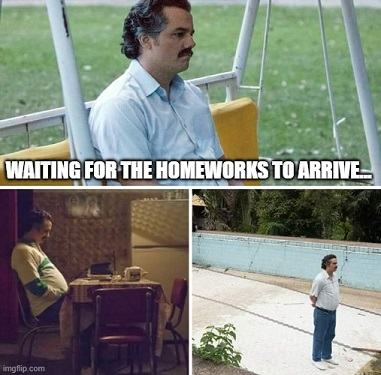